<a href="https://colab.research.google.com/github/nadavo11/K_means_cluster/blob/master/EM_Clustering_with_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GMM implementation with K-Means as an initial Model

The Gaussian Mixture Model is discussed in previous paper, in this repository. there we talk about it's need of an initial "guess" model, for the algorithm to start, and experiment with initiatng at random (K - Gaussians picked at random, defined by:
- $\mu_j$ - the mean of each gaussian
- ${\sigma_j}^2 $ - the covariance (matrix) of each gaussian
- $\phi_j$ - the "amplitude" of each gaussian
)

this time we will try a more interesting method - use the K means algorithm's output to initiate $µ_j$ . K- means is thorouly explained in another paper in this repository, and is "hard" algorithm, in contrast to EM, which is considerd "soft". in a few iterations,we get very close tothe conclution of the actual $/mu_j$


in this example, we are given two gaussians:
$µ_1 = \begin{bmatrix}
-1 \\
-1 
\end{bmatrix}$

$µ_2 = \begin{bmatrix}
1 \\
1 
\end{bmatrix}$

$\Sigma_1 = \begin{bmatrix}
0.8 & 0 \\
0 & 0.8
\end{bmatrix}$

$\Sigma_2 = \begin{bmatrix}
0.75 & -0.2 \\
-0.2 & 0.6
\end{bmatrix}$

we are given the probability for the first label:

$P_Z(1) = 0.7$

Let us define the datapiont generator:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 10000
k=2
d=2
# first Gussian
mean_1 = [-1, -1]
cov_1 = [[0.75, -0.2], [-0.2, 0.6]]

# second Gussian
mean_2 = [1, 1]
cov_2 = [[0.8, 0], [0, 0.8]]


def generate_normal_datapoint(guaussian_dist):
    mean = guaussian_dist[0]
    cov = guaussian_dist[1]
    dp = np.random.multivariate_normal(mean, cov,  check_valid='warn', tol=1e-8)
    dp = [dp[0],dp[1]]
    return dp

now we will make a dataset

In [ ]:
colors = []
data = []
for i in range(N):
    z = np.random.binomial(1, 0.7)
    d = {1: (mean_1, cov_1), 2: (mean_2, cov_2)}
    data.append(generate_normal_datapoint(d[z+1]))
    colors.append(np.random.uniform(0,1)/4+3*z/4)
    

now, lets plot the data (revealing the source of each data point) 

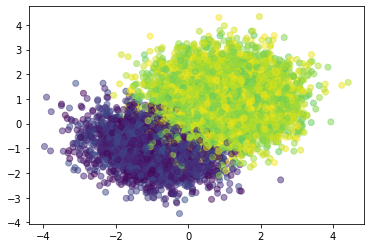

In [ ]:
data = np.array(data)

#colors = np.random.rand(N)
plt.scatter(data[:,0], data[:, 1], c=colors, alpha=0.5)
plt.show()

this time we will use the EM algorithm to cluster the data.

pseudo code: The EM algorithm goes as follows

here is EM algorithm in pseudo code

1.until convergence, repeat:
    
   -E-step:
   1. For each data point $x_i$:

        1. Compute the probability that $x_i$ belongs to each of the clusters, $p_{i,j}$

        2. Use these probabilities to compute the expected value of the cluster assignment, $w(i,j) = \frac{P(x_i \in Z_j)*\phi_j}{ \sum_{j = 0}^{k} P(x_i \in Z_j) \cdot \phi_j}$

   -M-step:
   1. For each cluster $j$:

        1. compute the new mean, $\mu_j$

        2. compute the new variance, $\sigma^2_j$

        4. compute the new prior, $ \phi_j$
        
        
this is what the implementation looks like:

In [ ]:
import numpy as np
import scipy as sp
from scipy.stats import multivariate_normal as P


def E_step(data, phi, mu, sigma):
    """
       Perform E-step on GMM model
       Each datapoint will find its corresponding best cluster center
       ---
       Inputs:
            data: (n, d) array, where n is # of data points and d is # of dimensions
            phi: (k, d) array, where k is # of clusters
            mu: (k, d) array, where k is # of clusters and d is # of dimensions
            sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

       Returns:
            'w': (k,n) array indicating the cluster of each data point
                        where k is # of clusters and n is # of data points
       """
    n = len(data)
    k = len(phi)
    w = np.zeros((k, n))
    log_likelyhood = 0
    
    for i in range(n):
        norm_i = 0
        for j in range(k):
            w[j, i] = P(mu[j], sigma[j]).pdf(data[i]) * phi[j]
            norm_i += w[j, i]
        w[:, i] /= norm_i
        
        log_likelyhood -= np.log(norm_i)    # compute log-likelyhood
    return w, log_likelyhood


def M_step(data, w, phi, mu, sigma):
    """
    M-step: Update our estimate of μ, σ2 and using the new values of the latent variables z.
    Inputs:
        clusters: (n) array indicating the cluster of each data point
        data: (n, d) array, where n is # of data points and d is # of dimensions
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions

    Returns:
        mu: (k, d) array, where k is # of clusters and d is # of dimensions
        sigma: (k, d, d) array, where k is # of clusters and d is # of dimensions
    """
    sum_of_all_w = np.sum(w)
    # iterate over each gaussian, calculate μ, σ2:

    for j in range(len(mu)):
        sum_over_wj = np.sum(w[j])
        # μ <- (1/sum over wj) * weighted sum over all the data points
        mu[j] = np.sum(np.array([xi*w[j,i] for i, xi in enumerate(data)]), axis=0) / sum_over_wj
        # σ2 <- wheighted sum over all the data points in cluster((datapoint value - μ_new)**2)
        sigma[j] = np.sum(np.array([np.outer((xi - mu[j]).T, xi - mu[j]) * w[j, i] for i, xi in enumerate(data)]), axis=0)/sum_over_wj

        phi[j] = sum_over_wj/sum_of_all_w

    return phi, mu, sigma

# Input: data, model

def EM(data, initial_model):
    # 1. Initialize model parameters
    phi = initial_model[0]
    mu = initial_model[1]
    sigma = initial_model[2]

    # 2. while not converged:
    converged = False
    i = 0
    iteration_log_likelihood = [0.0]
    while not converged and i<150:

        # 2.1     E-step: compute expected value of latent variable given current parameters
        w,lol = E_step(data , phi, mu, sigma)
        iteration_log_likelihood.append(lol)
        # 4.     M-step: update parameters to maximize expected likelihood
        phi, mu, sigma = M_step(data, w, phi, mu, sigma)
        
        # Plot:
        if i%20 == 0 or i < 5:
            plt.scatter(data[:,0], data[:, 1], c=1+w[0]-w[1], alpha=0.1,cmap='RdYlBu')
            plt.title("iteration #" + str(i))
            plt.show()
            print("φ: ",phi,"\n\nμ: ", mu,"\n\nσ2: ", sigma,"\n\nlog likelyhood: ", lol)
        i += 1
        converged = (abs(iteration_log_likelihood[i]-iteration_log_likelihood[i-1]) < 0.0001)
    # 5. return model
    return phi, mu, sigma,  iteration_log_likelihood




Model Initialization

first, we will need an initial model to start with. EM algorithm demands initial value  $\theta_0$ ie. initial values 
for:  $\mu_j , \sigma^2_j , \phi_j$

this time we will try to use K - means algorithm to help us generate the initial guess.
k-means outputs, as its name indicates, k - vctors, representing the means, $\mu_j$ of the predicted gaussians.  
this is an asset for us, as $\mu_j$ is an important part of the model.

but we need not stop there, as K-means inner operation deals with anuther vital piece of information: the size of each predicted cluster.
we can leverage this information to estimate $\phi_j$ for our initial guess: 

$\phi_j = P(Z = j) $ 

so K-means predicts:

$\phi_j = \frac{|cluster_j| }{|X|}$ 

where $|X|$ is the number of datapoints

furthermore, after estimating $mu$, and fetching the clusters predicted by k-means nothing stops us from getting a pretty good initial guess of $\sigma_j^2$:

$\sigma_j^{2 ,(0)} = \frac{1}{n} $  $\sum_{x \in cluster_j} (x -\mu_j^{(0)})^2 $
as this is a fair assumption for the value of $\sigma^2$ given the cluster.

so, we get valuable information at a low computational price.


In [ ]:
def K_means_cluster(k, data):
    # 1. randomly select k data points as
    #    centroids
    centroids = []
    for i in range(k):
        mean = np.random.uniform(-3,3,size=2)
        centroids.append(mean)
    i=0
    dif = 1
    tol= 0.001
    # 3. repeat until the centroids converge:
    while (i <= 15) and dif > tol: #TODO: add condition
        previous_centroids = np.array(centroids)

        # 2. calculate the distance between
        #    each data point and each centroid
        d = []
        for dp in data:
            distance = [np.linalg.norm(dp - ci) for ci in centroids]
            d.append(distance)
        d = np.array(d)


        # 4. assign each data point to the cluster with the nearest centroid
        clusters = [[], []]
        for j, dp in enumerate(d):
            closest_centroid = np.argmin(dp)
            clusters[closest_centroid].append(list(data[j]))

        fig = plt.figure()
        ax1 = fig.add_subplot()
        colors = ['r','b','g','y']
        for n in range(k):
            x = [row[0] for row in clusters[n]]
            y = [row[1] for row in clusters[n]]
            ax1.scatter( x, y , c=colors[n%4],alpha=0.03, label='cluster'+str(n))

        ax1.scatter([row[0] for row in np.array(centroids)], [row[1] for row in np.array(centroids)], c='m',marker="x",label='centroids')


        plt.legend(loc='upper left');
        plt.title("K-means iteration #" + str(i))
        plt.show()

        # 5. recalculate the centroid of each cluster
        for j, c in enumerate(clusters):
            centroids[j] = np.mean(c,axis=0)
        
        #calculate the convergence condition
        dif = 0
        for j, c in enumerate(centroids):
            dif += abs(np.linalg.norm(c-np.array(previous_centroids[j])))
        print("dif", dif)
        
        i +=1
    # phi is the probability of each cluster in the data
    phi =np.array([len(clusters[t])/len(data) for t in range(k)])
    
    sigma = np.zeros((k,2,2))
    for j, c in enumerate(clusters):
        sigma[j] = np.mean([np.outer((d - centroids[j]).T, d - centroids[j]) for d in c],axis = 0)
        
    return phi, np.array(centroids), sigma



In [ ]:
def initial_model(k,d,data):
    """

    :param k: # of Gaussians in model
    :param d: # of dimentions of datapoints
    :return: an arbitrary initial condition  model for EM. containing:
             phi: amplitude of Gaussians, np array (k)
             mu: np array(k,d)
             sigma: covariance matrix of gausians, np aray (k,d,d)


    """

    phi, mu, sigmas = K_means_cluster(k, data)
    
   # sigmas = np.zeros((k,d,d))
   # for i in range(k):
   #     sigma = np.random.rand(d, d)
   #     sigma = np.dot(sigma, sigma.T)
   #     sigmas[i] = sigma
    
    print("phi: ",phi,"\n\nmu: ", mu,"\n\nsigma: ", sigma)
    return phi, mu, sigmas

convergence conditon:

we will also like to decide when to stop the algorithm. for one thing, we will limit the maximal # of iterations to a fixed number. for another, the algorithm increases the log likelihood, i.e., $ log P(x^n |/theta^t$
so we will calculate the log likelihood at each step, as follows:

Log Likelihood:

$ log P(x^n |\theta ^t )= log(\sum_j P(x^n , z^n ;\theta ^t))$


$= log( \prod_i\sum_j  N(x_i, \mu_j , \sigma^2_j ; \theta ^t)* \phi_j)$


$= \sum_i log( \sum_j  w(j,i))$

$= $
and compare to previous value, to check for convergence.

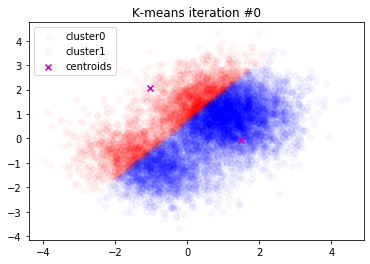

dif 1.9776293522026018


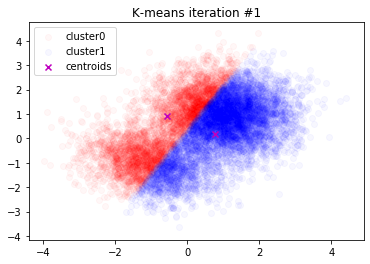

dif 0.8205236440912959


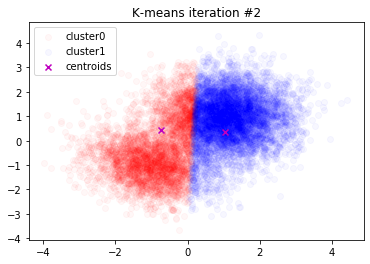

dif 1.3274853908642177


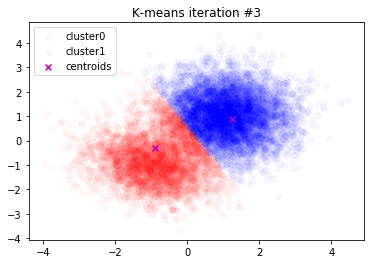

dif 0.6529147616571733


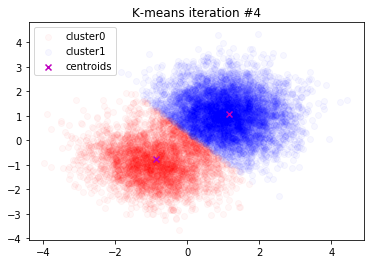

dif 0.17189618138845258


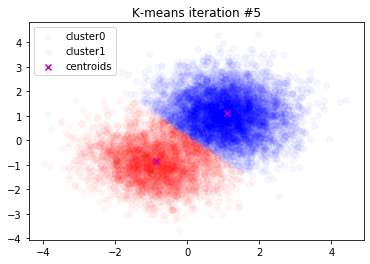

dif 0.05676234525394865


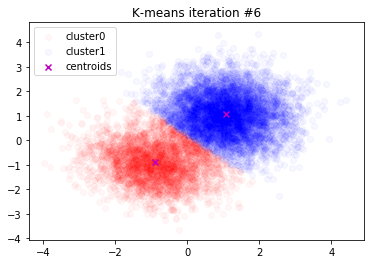

dif 0.017009560104371574


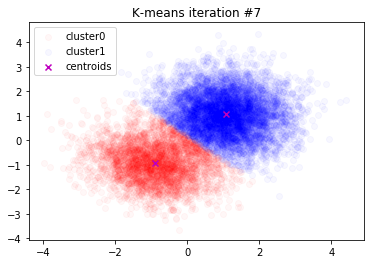

dif 0.00559162031547159


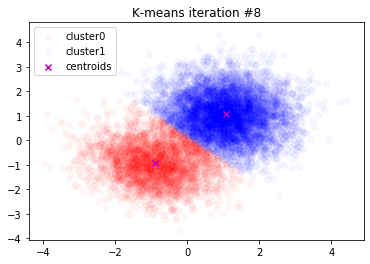

dif 0.0020532402576476094


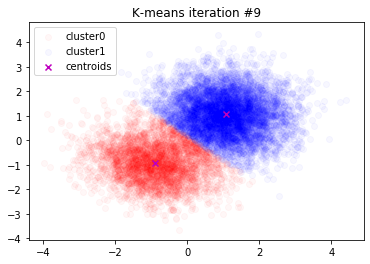

dif 0.0007843143594964384
phi:  [0.3458 0.6542] 

mu:  [[-0.89886392 -0.90973937]
 [ 1.073325    1.09078876]] 

sigma:  [[[ 0.80853244  0.00558844]
  [ 0.00558844  0.77154055]]

 [[ 0.78860844 -0.19893516]
  [-0.19893516  0.59491177]]]


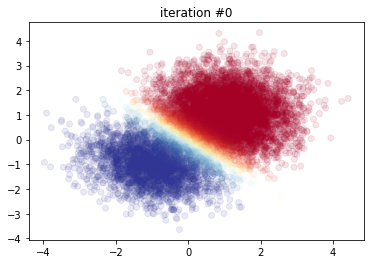

φ:  [0.3351903 0.6648097] 

μ:  [[-0.90342499 -0.92407906]
 [ 1.04415048  1.06609225]] 

σ2:  [[[ 0.798713   -0.10593642]
  [-0.10593642  0.63103303]]

 [[ 0.73984079 -0.06518861]
  [-0.06518861  0.71587652]]] 

log likelyhood:  30577.735402193743


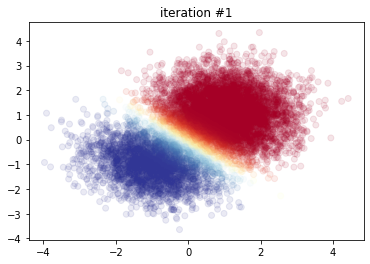

φ:  [0.32869118 0.67130882] 

μ:  [[-0.91488969 -0.93929036]
 [ 1.03090892  1.05427275]] 

σ2:  [[[ 0.80067307 -0.11074206]
  [-0.11074206  0.62209503]]

 [[ 0.7540677  -0.05162435]
  [-0.05162435  0.72787872]]] 

log likelyhood:  30530.377829306188


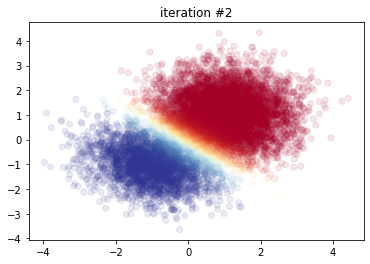

φ:  [0.32369425 0.67630575] 

μ:  [[-0.92756116 -0.95299462]
 [ 1.02259707  1.0461023 ]] 

σ2:  [[[ 0.79384993 -0.11983304]
  [-0.11983304  0.61158487]]

 [[ 0.76190404 -0.04405362]
  [-0.04405362  0.7351831 ]]] 

log likelyhood:  30519.20742910378


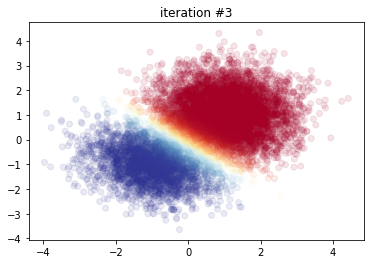

φ:  [0.31954709 0.68045291] 

μ:  [[-0.93958359 -0.96472727]
 [ 1.01635728  1.03942817]] 

σ2:  [[[ 0.78511192 -0.12894213]
  [-0.12894213  0.60236039]]

 [[ 0.76725368 -0.03861661]
  [-0.03861661  0.7409802 ]]] 

log likelyhood:  30512.198487047335


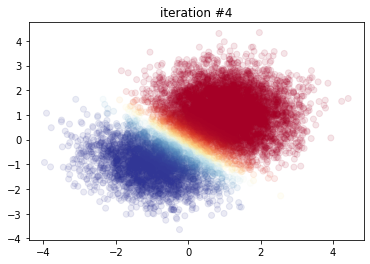

φ:  [0.31602687 0.68397313] 

μ:  [[-0.9503368  -0.97458407]
 [ 1.01125908  1.03366764]] 

σ2:  [[[ 0.77664462 -0.13695928]
  [-0.13695928  0.59479618]]

 [[ 0.77143217 -0.03414589]
  [-0.03414589  0.74610119]]] 

log likelyhood:  30506.96608748746


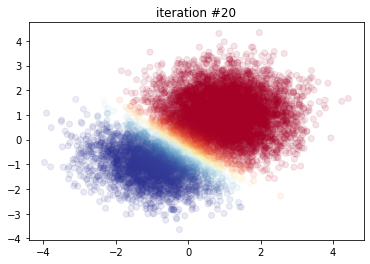

φ:  [0.29847426 0.70152574] 

μ:  [[-1.00486264 -1.01994586]
 [ 0.98537753  1.00271975]] 

σ2:  [[[ 0.73363552 -0.17314005]
  [-0.17314005  0.56404382]]

 [[ 0.79318912 -0.00905981]
  [-0.00905981  0.77695849]]] 

log likelyhood:  30493.15603257302


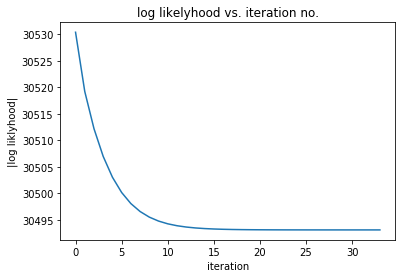

In [ ]:
k=2
d=2

phi, mu, sigma, lol = EM(data,initial_model(k,d,data))

plt.plot(range(len(lol[2:])),lol[2:])
plt.title("log likelyhood vs. iteration no.")
plt.xlabel("iteration")
plt.ylabel("|log liklyhood|")
plt.show()

wow! less then half the iterations, when also counting the K-means iterations, which are way less resource intensive!
this shows us the power of combining soft and hard algoritms, and the value of analizing our data from mutiple points of view.